In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import re

from keras.models import Model
from keras.layers import Embedding, Dense, Input
from keras.layers.recurrent import LSTM
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint

!pip install corus
from corus import load_lenta

from collections import Counter

Could not fetch URL https://pypi.org/simple/pip/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries exceeded with url: /simple/pip/ (Caused by SSLError(SSLError("bad handshake: Error([('SSL routines', 'tls_process_server_certificate', 'certificate verify failed')])"))) - skipping


In [2]:
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, Dropout, TimeDistributed, Activation
from tensorflow.keras.callbacks import ModelCheckpoint
# from keras.layers.recurrent import LSTM



from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences

#### load and preprocess dataset

In [3]:
# !wget https://github.com/yutkin/Lenta.Ru-News-Dataset/releases/download/v1.0/lenta-ru-news.csv.gz

In [4]:
lenta_path = 'data/1/lenta-ru-news.csv.gz'
num_rows = 10_000

In [5]:
records = load_lenta(lenta_path)
df = pd.DataFrame([[rec.text, rec.title] for _, rec in zip(range(num_rows), records)], columns=['text', 'title'])

df['title'] = df['title'].apply(lambda x: re.sub("\xa0", " ", x))

reg = re.compile('[^а-яА-Я0-9.,_-_ ]')
df['cleaned_text'] = [reg.sub('', text) for text in df.text.apply(lambda x: x.lower())]
df['cleaned_title'] = [reg.sub('', title) for title in df.title.apply(lambda x: x.lower())]


train_inputs, test_inputs, train_labels, test_labels = train_test_split(df['cleaned_text'].values, df['cleaned_title'].values, test_size=0.1, shuffle=False)

reg = re.compile('[^а-яА-Я_ _-]')
df['tokenized_text'] = [reg.sub(' ', text).split() for text in df.text.apply(lambda x: x.lower())]
df['tokenized_title'] = [reg.sub(' ', title).split() for title in df.title.apply(lambda x: x.lower())]


train_input_tokens, test_input_tokens, train_label_tokens, test_label_tokens = train_test_split(df['tokenized_text'].values, df['tokenized_title'].values, test_size=0.1, shuffle=False)

In [6]:
df.head()

,text,title,cleaned_text,cleaned_title,tokenized_text,tokenized_title
0,Вице-премьер по социальным вопросам Татьяна Го...,Названы регионы России с самой высокой смертно...,вицепремьер по социальным вопросам татьяна гол...,названы регионы россии с самой высокой смертно...,"[вице-премьер, по, социальным, вопросам, татья...","[названы, регионы, россии, с, самой, высокой, ..."
1,Австрийские правоохранительные органы не предс...,Австрия не представила доказательств вины росс...,австрийские правоохранительные органы не предс...,австрия не представила доказательств вины росс...,"[австрийские, правоохранительные, органы, не, ...","[австрия, не, представила, доказательств, вины..."
2,Сотрудники социальной сети Instagram проанализ...,Обнаружено самое счастливое место на планете,сотрудники социальной сети проанализировали п...,обнаружено самое счастливое место на планете,"[сотрудники, социальной, сети, проанализировал...","[обнаружено, самое, счастливое, место, на, пла..."
3,С начала расследования российского вмешательст...,В США раскрыли сумму расходов на расследование...,с начала расследования российского вмешательст...,в сша раскрыли сумму расходов на расследование...,"[с, начала, расследования, российского, вмешат...","[в, сша, раскрыли, сумму, расходов, на, рассле..."
4,Хакерская группировка Anonymous опубликовала н...,Хакеры рассказали о планах Великобритании зами...,хакерская группировка опубликовала новые доку...,хакеры рассказали о планах великобритании зами...,"[хакерская, группировка, опубликовала, новые, ...","[хакеры, рассказали, о, планах, великобритании..."


Build vocab


In [7]:
data = np.hstack(df['tokenized_text'].values)

counter = Counter(data)
count_pairs = sorted(counter.items(), key=lambda x: (-x[1], x[0]))

words, _ = list(zip(*count_pairs))
word_to_id = dict(zip(words, range(len(words))))

vocabulary = len(word_to_id)

reversed_dictionary = dict(zip(word_to_id.values(), word_to_id.keys()))

In [409]:
# train_input_ids = [[word_to_id[w] for w in text] for text in train_input_tokens]
# train_label_ids = [[word_to_id[w] for w in text] for text in train_label_tokens]
# test_input_ids = [[word_to_id[w] for w in text] for text in test_input_tokens]
# test_label_ids = [[word_to_id[w] for w in text] for text in test_label_tokens]

sber vocab

In [15]:
ideas = pd.read_csv('/Users/aydar/Desktop/NLP/data/sber_idea/ideas.csv')

In [16]:
reg = re.compile('[^а-яА-Я0-9.,_-_ ]')
ideas['cleaned_text'] = [reg.sub('', text) for text in ideas.content_raw.apply(lambda x: x.lower())]

reg = re.compile('[^а-яА-Я_ ]')
ideas['tokenized_text'] = [reg.sub(' ', text).split() for text in ideas.content_raw.apply(lambda x: x.lower())]

In [315]:
counter_ideas = Counter(np.hstack(ideas.tokenized_text))
count_pairs_ideas = sorted(counter_ideas.items(), key=lambda x: (-x[1], x[0]))

words_ideas, _ = list(zip(*count_pairs_ideas))
word_to_id_ideas = dict(zip(words_ideas, range(len(words_ideas))))

vocabulary_ideas = len(word_to_id_ideas)

reversed_dictionary_ideas = dict(zip(word_to_id_ideas.values(), word_to_id_ideas.keys()))

Build model

In [8]:
# hidden_size = 250
# num_steps = 20
# batch_size = 32
# # use_dropout=True

# enc_vocabulary = {i:word_to_id[i] for i in word_to_id if word_to_id[i] < 10000}
# dec_vocabulary = {i:word_to_id_ideas[i] for i in word_to_id_ideas if word_to_id_ideas[i] < 5000}

In [9]:
# config = {'hidden_size': 500,
#           'lstm_units': 250,
#           'max_input_length':1000,
#           'max_target_length': 40, 
#           'enc_vocabulary': enc_vocabulary, 
#           'dec_vocabulary': dec_vocabulary}


In [10]:
# X_padded = pad_sequences(tokenized_text_ids, config['max_input_length'])
# y_padded = pad_sequences(tokenized_title_ids, config['max_target_length'])

# print(X_padded.shape)
# print(y_padded.shape)

In [11]:
# sum_unknown_X = [np.mean(np.array(x) == -1) for x in tokenized_text_ids]
# plt.hist(sum_unknown_X)

In [89]:
def get_config(input_tokens, label_tokens, input_voc_size=10000, output_voc_size=10000):
    # input
    data_input = np.hstack(input_tokens)

    counter = Counter(data_input)
    count_pairs = sorted(counter.items(), key=lambda x: (-x[1], x[0]))

    words, _ = list(zip(*count_pairs))
    
    enc_vocabulary = dict(zip(words, range(2, min([len(words)+2, input_voc_size+2]))))
    enc_vocabulary['UNK'] = 0
    enc_vocabulary['PAD'] = 1

    rev_enc_vocabulary = dict(zip(enc_vocabulary.values(), enc_vocabulary.keys()))
    
    # labels
    data_labels = np.hstack(label_tokens)

    counter = Counter(data_labels)
    count_pairs = sorted(counter.items(), key=lambda x: (-x[1], x[0]))

    words, _ = list(zip(*count_pairs))
    
    dec_vocabulary = dict(zip(words, range(3, min([len(words)+3, output_voc_size+3]))))
    dec_vocabulary['UNK'] = 0
    dec_vocabulary['START'] = 1
    dec_vocabulary['END'] = 2

    rev_dec_vocabulary = dict(zip(dec_vocabulary.values(), dec_vocabulary.keys()))
    
    
    
    config = {'hidden_size': 500,
              'lstm_units': 250,
              'max_input_length':1000,
              'max_target_length': 40, 
              'enc_vocabulary': enc_vocabulary,
              'dec_vocabulary': dec_vocabulary,
              'rev_enc_vocabulary': rev_enc_vocabulary,
              'rev_dec_vocabulary': rev_dec_vocabulary}
    
    return config
    
class Summarizer():
    def __init__(self, config):
        self.hidden_size = config['hidden_size']
        self.max_input_length = config['max_input_length']
        self.max_target_length = config['max_target_length']
        lstm_units = config['lstm_units']
        
        self.enc_vocabulary, self.dec_vocabulary = config['enc_vocabulary'], config['dec_vocabulary']
        
        # encoder
        enc_input = Input(shape=(None,), name='enc_inputs')
        enc_embedding = Embedding(input_dim=len(self.enc_vocabulary), output_dim=self.hidden_size, 
                                  input_length=self.max_input_length)
        enc_lstm = LSTM(lstm_units, return_state=True)#, return_sequences=True)
        enc_dense = Dense(self.hidden_size, activation='softmax')
        
        enc_output, enc_state_h, enc_state_c = enc_lstm(enc_embedding(enc_input))
        
        self.encoder_model = Model(enc_input, [enc_output, enc_state_h, enc_state_c], name='Encoder')
        
        
        # training model
        dec_input = Input(shape=(None, len(self.dec_vocabulary)), name='dec_inputs')
        dec_lstm = LSTM(lstm_units, return_state=True, return_sequences=True)
        dec_dense = Dense(len(self.dec_vocabulary), activation='softmax')
        
        
        dec_output, dec_state_h, dec_state_c  = dec_lstm(dec_input, initial_state=[enc_state_h, enc_state_c])
        dec_output = dec_dense(dec_output)
        
        self.model = Model([enc_input, dec_input], dec_output, name='Training')
        self.model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        
        # decoder
        dec_input_states = [Input(shape=lstm_units,), Input(shape=lstm_units,)]
        dec_output, dec_state_h, dec_state_c  = dec_lstm(dec_input, initial_state=dec_input_states)
        
        dec_output = dec_dense(dec_output)
        
        self.decoder_model = Model([dec_input] + dec_input_states, [dec_output] + [dec_state_h, dec_state_c],
                                   name='Decoder')
#         self.max_input_seq_length = self.max_input_length
#         self.num_input_tokens = len(enc_vocabulary)
#         self.num_target_tokens = len(dec_vocabulary)

    def fit(self, X_train, y_train, X_test, y_test, epochs=10, batch_size=32, cache_path='cache_dir/models'):
        
        checkpoint = ModelCheckpoint(cache_path)
        
        X_train = self.transform_input(X_train)
        X_test = self.transform_input(X_test)
        y_train = self.transform_labels(y_train)
        y_test = self.transform_labels(y_test)
        
        train_generator = self.generate_batch(X_train, y_train, batch_size)
        validation_generator = self.generate_batch(X_test, y_test, batch_size)
        
#         (x1, x2), y = next(train_generator)
        
#         print(x1.shape)
#         print(x2.shape)
#         print(y.shape)
        
        
#         print(x1[0])
#         print(x2[0])
#         print(y[0])
#         print(y[0, :, 0])
#         print(y[0, 0, :])
#         print(np.max(y[0, 0, :]))
#         print(np.max(y))
        
        self.model.fit_generator(train_generator, steps_per_epoch=len(X_train)//batch_size,
                       validation_data=validation_generator, validation_steps=len(y_train)//batch_size,
                      callbacks=[checkpoint])
        
    def summarize(self, text):
        
        input_seq = []
        input_wids = []
        for word in input_text.lower().split(' '):
            idx = 1  # default [UNK]
            if word in self.enc_vocabulary:
                idx = self.enc_vocabulary[word]
            input_wids.append(idx)
        input_seq.append(input_wids)
        input_seq = pad_sequences(input_seq, self.max_input_seq_length)
        states_value = self.encoder_model.predict(input_seq)
        target_seq = np.zeros((1, 1, self.num_target_tokens))
        target_seq[0, 0, self.target_word2idx['START']] = 1
        target_text = ''
        target_text_len = 0
        terminated = False
        
#         print(self.target_idx2word)
#         print(len(self.target_idx2word))
        while not terminated:
            output_tokens, h, c = self.decoder_model.predict([target_seq] + states_value)

            sample_token_idx = np.argmax(output_tokens[0, -1, :])
            sample_word = self.target_idx2word[sample_token_idx]
            target_text_len += 1

            if sample_word != 'START' and sample_word != 'END':
                target_text += ' ' + sample_word

            if sample_word == 'END' or target_text_len >= self.max_target_seq_length:
                terminated = True

            target_seq = np.zeros((1, 1, self.num_target_tokens))
            target_seq[0, 0, sample_token_idx] = 1

            states_value = [h, c]
        return target_text.strip()
        
    def generate_batch(self, X, y, batch_size=32):
        num_batches = len(X) // batch_size
        while True:
            for batchIdx in range(0, num_batches):
                start = batchIdx * batch_size
                end = (batchIdx + 1) * batch_size
                encoder_input_data_batch = pad_sequences(X[start:end], self.max_input_length)
                decoder_target_data_batch = np.zeros(shape=(batch_size, self.max_target_length, len(self.dec_vocabulary)))
                decoder_input_data_batch = np.zeros(shape=(batch_size, self.max_target_length, len(self.dec_vocabulary)))
                for lineIdx, target_word_inds in enumerate(y[start:end]):
                    for pos, word_ind in enumerate(target_word_inds):
#                         print(word_ids)
                        decoder_input_data_batch[lineIdx, pos, word_ind] = 1
                        
                        if pos > 0: #??????????????/
                            decoder_target_data_batch[lineIdx, pos-1, word_ind] = 1

#                 for lineIdx, target_words in enumerate(y[start:end]):
#                     print('target_words: ', target_words)
#                     for idx, w in enumerate(target_words):
#                         print('w = ', w)
#                         w2idx = 0  # default [UNK]
#                         if w in self.dec_vocabulary:
#                             print('w in self.dec_vocabulary')
#                             w2idx = self.dec_vocabulary[w]
#                         if w2idx != 0:
#                             decoder_input_data_batch[lineIdx, idx, w2idx] = 1
#                             if idx > 0:
#                                 decoder_target_data_batch[lineIdx, idx - 1, w2idx] = 1
                                
#                 print('encoder_input_data_batch: ', encoder_input_data_batch[0].shape)#, encoder_input_data_batch[0])
#                 print('decoder_input_data_batch: ', decoder_input_data_batch[0].shape)#, decoder_input_data_batch[0])
#                 print('decoder_target_data_batch: ', decoder_target_data_batch[0].shape)#, decoder_target_data_batch[0])
                yield [encoder_input_data_batch, decoder_input_data_batch], decoder_target_data_batch
    
    def transform_input(self, texts):
#         reg = re.compile('[^а-яА-Я_ _-]')
#         tokenized_text = [reg.sub('', text) for text in texts.apply(lambda x: x.lower())]
        tokenized_text = texts
        tokenized_text_ids = [[self.enc_vocabulary[token] if token in self.enc_vocabulary else self.enc_vocabulary['UNK'] for token in text] for text in tokenized_text]
        padded_text_ids = pad_sequences(tokenized_text_ids, self.max_input_length)
        
        return padded_text_ids
        
    def transform_labels(self, titles):
#         reg = re.compile('[^а-яА-Я_ _-]')
#         tokenized_title = [reg.sub(' ', title).split() for title in titles.apply(lambda x: x.lower())]
        tokenized_title = titles
        tokenized_title_ids = [[self.dec_vocabulary[token] if token in self.dec_vocabulary else self.dec_vocabulary['UNK'] for token in ['START']+title+['END']] for title in tokenized_title]
        padded_title_ids = pad_sequences(tokenized_title_ids, self.max_target_length)
        
        return padded_title_ids
#         tokenized_title = [['START']+title+['END'] for title in tokenized_title]
#         padded_title = pad_sequences(tokenized_title, self.max_target_length)
        
#         print(padded_title)
#         return padded_title
        
    
    def encode(self, source_tokens):
        encoding, enc_state_h, enc_state_c = self.encoder_model(source_tokens)
        
        return encoding
    
    def decode_sample(self, encoding, hidden_state):
        pass

In [90]:
# %%time
# config = get_config(df.tokenized_text, ideas.tokenized_text)

In [91]:
s = Summarizer(config)

In [92]:
n = 1000
# s.fit(train_input_ids[:n], train_label_ids[:n], test_input_ids[:n], test_label_ids[:n])
# s.fit(train_inputs[:n], train_labels[:n], test_inputs[:n], test_labels[:n])
s.fit(train_input_tokens[:n], train_label_tokens[:n], test_input_tokens[:n], test_label_tokens[:n])

(32, 40, 10003)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
1.0
1.0
31/31 [==============================] - 138s 4s/step - loss: 4.2370 - accuracy: 0.8417 - val_loss: 1.0967 - val_accuracy: 0.8689


In [529]:
# 'hidden_size': 500,
# 'lstm_units': 250,
# 'max_input_length': 1000,
# 'max_target_length': 40,

# print(len(config['enc_vocabulary']))
# print(len(config['dec_vocabulary']))
# # config

In [596]:
s.encoder_model.summary()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
enc_inputs (InputLayer)      [(None, None)]            0         
_________________________________________________________________
embedding_71 (Embedding)     (None, None, 250)         2500000   
_________________________________________________________________
lstm_142 (LSTM)              [(None, 250), (None, 250) 501000    
Total params: 3,001,000
Trainable params: 3,001,000
Non-trainable params: 0
_________________________________________________________________


In [597]:
s.decoder_model.summary()

Model: "Decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dec_inputs (InputLayer)         [(None, None, 5003)] 0                                            
__________________________________________________________________________________________________
input_114 (InputLayer)          [(None, 250)]        0                                            
__________________________________________________________________________________________________
input_115 (InputLayer)          [(None, 250)]        0                                            
__________________________________________________________________________________________________
lstm_143 (LSTM)                 [(None, None, 250),  5254000     dec_inputs[0][0]                 
                                                                 input_114[0][0]            

In [599]:
s.model.summary()

Model: "Training"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_71 (Embedding)        (None, None, 250)    2500000     enc_inputs[0][0]                 
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None, 5003)] 0                                            
__________________________________________________________________________________________________
lstm_142 (LSTM)                 [(None, 250), (None, 501000      embedding_71[0][0]               
___________________________________________________________________________________________

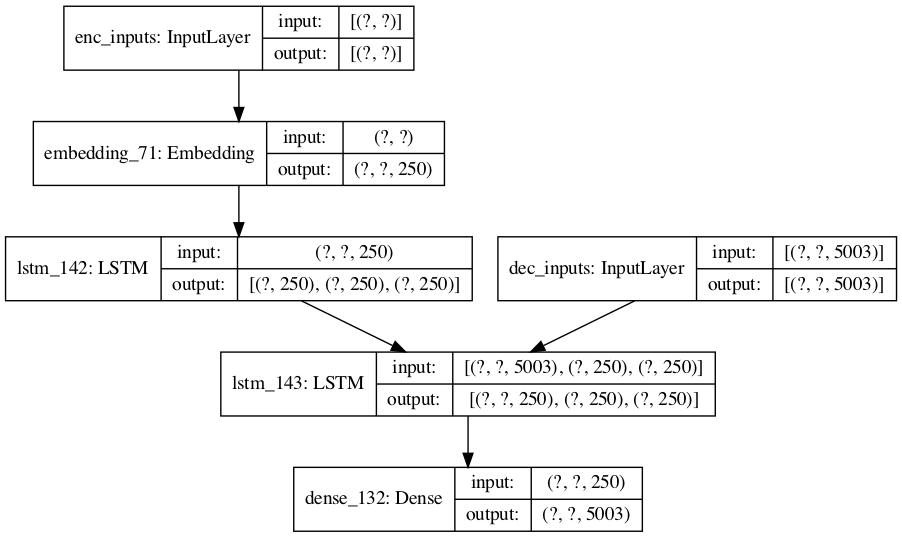

In [598]:
import tensorflow as tf

tf.keras.utils.plot_model(
    s.model,
#     to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=100,
)

#### try(

In [104]:

model = Sequential()
model.add(Embedding(vocabulary, hidden_size, input_length=num_steps))
model.add(LSTM(hidden_size, return_sequences=True))
# model.add(LSTM(hidden_size, return_sequences=True))

model.add(Dropout(0.5))
model.add(TimeDistributed(Dense(vocabulary)))
# model.add(Dense(vocabulary))
model.add(Activation('softmax'))

optimizer = Adam()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 250)           31056750  
_________________________________________________________________
lstm_7 (LSTM)                (None, 20, 250)           501000    
_________________________________________________________________
dropout_38 (Dropout)         (None, 20, 250)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 124227)        31180977  
_________________________________________________________________
activation_11 (Activation)   (None, 20, 124227)        0         
Total params: 62,738,727
Trainable params: 62,738,727
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
from keras.utils import to_categorical
class KerasBatchGenerator(object):

    def __init__(self, data, num_steps, batch_size, vocabulary, skip_step=5):
        self.data = data
        self.num_steps = num_steps
        self.batch_size = batch_size
        self.vocabulary = vocabulary
        # this will track the progress of the batches sequentially through the
        # data set - once the data reaches the end of the data set it will reset
        # back to zero
        self.current_idx = 0
        # skip_step is the number of words which will be skipped before the next
        # batch is skimmed from the data set
        self.skip_step = skip_step

    def generate(self):
        x = np.zeros((self.batch_size, self.num_steps))
        y = np.zeros((self.batch_size, self.num_steps, self.vocabulary))
        while True:
            for i in range(self.batch_size):
                if self.current_idx + self.num_steps >= len(self.data):
                    # reset the index back to the start of the data set
                    self.current_idx = 0
                # print(self.current_idx)
                # print(self.num_steps)
                # print(self.data[self.current_idx:self.current_idx + self.num_steps])
                # print(x)
                # print(x[i, :])
                x[i, :] = self.data[self.current_idx:self.current_idx + self.num_steps]
                temp_y = self.data[self.current_idx + 1:self.current_idx + self.num_steps + 1]
                # convert all of temp_y into a one hot representation
                y[i, :, :] = to_categorical(temp_y, num_classes=self.vocabulary)
                self.current_idx += self.skip_step
            yield x, y

In [ ]:
data_concat = [x for sentence in train_input_ids[:20] for x in sentence]

In [ ]:
train_data_generator = KerasBatchGenerator(data_concat, 
                                           num_steps=num_steps, 
                                           batch_size=1, 
                                           vocabulary=vocabulary,
                                           skip_step=num_steps)
# valid_data_generator = KerasBatchGenerator(valid_data, num_steps, batch_size, vocabulary,
#                                            skip_step=num_steps)

In [ ]:
checkpointer = ModelCheckpoint(filepath='checkpoints/' + '/model-{epoch:02d}.hdf5', verbose=1, save_freq=100)   

In [ ]:
model.fit_generator(train_data_generator.generate(), verbose=True)
# model.fit_generator(train_data_generator.generate(), verbose=True, callbacks=[checkpointer])



     13/Unknown - 9s 716ms/step - loss: 10.8224 - categorical_accuracy: 0.0615

KeyboardInterrupt: ignored

In [ ]:
data = next(train_data_generator.generate())

In [ ]:
prediction = model.predict(data[0])
predict_word = np.argmax(prediction[:, - 2, :])

# true_print_out += reversed_dictionary[test_data[num_steps + i]] + " "
# pred_print_out += reversed_dictionary[predict_word] + " "

In [ ]:
reversed_dictionary[predict_word]

'в'

In [ ]:
res.shape

(32, 20, 124227)

In [ ]:
!mkdir bert_cache
!mkdir bert_cache/transformer

In [ ]:
from transformers import BertTokenizer, TFBertModel
model_name = 'bert-base-multilingual-cased'


cache_dir = "bert_cache/"
cache_dir_models = cache_dir + "bert_models/"
cache_dir_tokenizers = cache_dir + "bert_tokenizers/"
tokenizer = BertTokenizer.from_pretrained(model_name, cache_dir=cache_dir_tokenizers)
bert_model = TFBertModel.from_pretrained(model_name, cache_dir=cache_dir_models)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
bert_tokenized_text = df['tokenized_text'].apply(lambda x: tokenizer.encode(x, max_length=512, truncation=True))
bert_tokenized_title = df['tokenized_title'].apply(lambda x: tokenizer.encode(x, max_length=32, truncation=True))


input_ids = pad_sequences(bert_tokenized_text, maxlen=512, truncating="post", padding="post")
label_ids = pad_sequences(bert_tokenized_title, maxlen=32, truncating="post", padding="post")

bert_text_train, bert_text_test, bert_title_train, bert_title_test = train_test_split(input_ids, label_ids, test_size=0.1)

In [ ]:
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.layers.recurrent import LSTM

from keras.preprocessing.sequence import pad_sequences



In [ ]:
# input_layer = Input(shape=(512), dtype='int64')
# bert = bert_model.bert(input_layer)
# lstm = LSTM(units=250, return_state=True)(bert[0])
# classifier = Dense(units=2000, activation='softmax')(lstm[0])
# model = Model(inputs=input_layer, outputs=classifier)

# model.layers[1].trainable = False
# model.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 512)]             0         
_________________________________________________________________
bert (TFBertMainLayer)       ((None, 512, 768), (None, 177853440 
_________________________________________________________________
lstm_3 (LSTM)                [(None, 250), (None, 250) 1019000   
_________________________________________________________________
dense_5 (Dense)              (None, 2000)              502000    
Total params: 179,374,440
Trainable params: 1,521,000
Non-trainable params: 177,853,440
_________________________________________________________________


In [ ]:
input_layer = Input(shape=(512), dtype='int64')
bert = bert_model.bert(input_layer)
classifier = Dense(units=119547, activation='softmax')(bert[0])
model = Model(inputs=input_layer, outputs=classifier)
model.summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 512)]             0         
_________________________________________________________________
bert (TFBertMainLayer)       ((None, 512, 768), (None, 177853440 
_________________________________________________________________
dense_6 (Dense)              (None, 512, 119547)       91931643  
Total params: 269,785,083
Trainable params: 91,931,643
Non-trainable params: 177,853,440
_________________________________________________________________


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'loss'])

In [ ]:
bert_text_train.shape

(900, 512)

In [ ]:
bert_title_train.shape

(900, 32)

In [ ]:
model(bert_text_train)

In [ ]:
model.fit(bert_text_train, bert_title_train, batch_size=32)

ValueError: in user code:

    /Users/aydar/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /Users/aydar/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/aydar/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/aydar/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/aydar/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/aydar/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /Users/aydar/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:749 train_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    /Users/aydar/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /Users/aydar/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    /Users/aydar/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /Users/aydar/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /Users/aydar/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:1535 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    /Users/aydar/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /Users/aydar/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/backend.py:4687 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    /Users/aydar/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 32) and (None, 512, 119547) are incompatible


In [ ]:
checkpointer = ModelCheckpoint(filepath='checkpoints/' + '/model-{epoch:02d}.hdf5', verbose=1)   

In [ ]:
# model.fit_generator(train_data_generator.generate(), len(train_data)//(batch_size*num_steps), num_epochs,
#                         validation_data=valid_data_generator.generate(),
#                         validation_steps=len(valid_data)//(batch_size*num_steps), callbacks=[checkpointer])

In [ ]:
model.fit()

#### from keras-text-summarization

In [ ]:
from collections import Counter

MAX_INPUT_SEQ_LENGTH = 1500
MAX_TARGET_SEQ_LENGTH = 50
MAX_INPUT_VOCAB_SIZE = 5000
MAX_TARGET_VOCAB_SIZE = 2000

In [ ]:
# def fit_text(X, Y, input_seq_max_length=None, target_seq_max_length=None):
X = train_input_tokens
Y = train_label_tokens
input_seq_max_length=None
target_seq_max_length=None


if input_seq_max_length is None:
    input_seq_max_length = MAX_INPUT_SEQ_LENGTH
if target_seq_max_length is None:
    target_seq_max_length = MAX_TARGET_SEQ_LENGTH
input_counter = Counter()
target_counter = Counter()
max_input_seq_length = 0
max_target_seq_length = 0

for line in X:
    text = [word.lower() for word in line.split(' ')]
    seq_length = len(text)
    if seq_length > input_seq_max_length:
        text = text[0:input_seq_max_length]
        seq_length = len(text)
    for word in text:
        input_counter[word] += 1
    max_input_seq_length = max(max_input_seq_length, seq_length)

for line in Y:
    line2 = 'START ' + line.lower() + ' END'
    text = [word for word in line2.split(' ')]
    seq_length = len(text)
    if seq_length > target_seq_max_length:
        text = text[0:target_seq_max_length]
        seq_length = len(text)
    for word in text:
        target_counter[word] += 1
        max_target_seq_length = max(max_target_seq_length, seq_length)

input_word2idx = dict()
for idx, word in enumerate(input_counter.most_common(MAX_INPUT_VOCAB_SIZE)):
    input_word2idx[word[0]] = idx + 2
input_word2idx['PAD'] = 0
input_word2idx['UNK'] = 1
input_idx2word = dict([(idx, word) for word, idx in input_word2idx.items()])

target_word2idx = dict()
for idx, word in enumerate(target_counter.most_common(MAX_TARGET_VOCAB_SIZE)):
    target_word2idx[word[0]] = idx + 1
target_word2idx['UNK'] = 0

target_idx2word = dict([(idx, word) for word, idx in target_word2idx.items()])

num_input_tokens = len(input_word2idx)
num_target_tokens = len(target_word2idx)

config = dict()
config['input_word2idx'] = input_word2idx
config['input_idx2word'] = input_idx2word
config['target_word2idx'] = target_word2idx
config['target_idx2word'] = target_idx2word
config['num_input_tokens'] = num_input_tokens
config['num_target_tokens'] = num_target_tokens
config['max_input_seq_length'] = max_input_seq_length
config['max_target_seq_length'] = max_target_seq_length

# return config

In [ ]:
fit_text

In [371]:
def transform_input_text(texts, max_input_seq_length=1000):
#     input_word2idx = {}
    temp = []
    for line in texts:
        x = []
        for word in line.lower().split(' '):
            wid = 1
            if word in word_to_id:
                wid = word_to_id[word]
            x.append(wid)
            if len(x) >= max_input_seq_length:
                break
        temp.append(x)
    temp = pad_sequences(temp, maxlen=max_input_seq_length)

    print(temp.shape)
    return temp, word_to_id

def transform_target_encoding(texts, max_target_seq_length=40):
    temp = []
    for line in texts:
        x = []
        line2 = 'START ' + line.lower() + ' END'
        for word in line2.split(' '):
            x.append(word)
            if len(x) >= max_target_seq_length:
                break
        temp.append(x)

    temp = np.array(temp)
    print(temp.shape)
    return temp

In [372]:
transform_input_text([' '.join(train_input_tokens[0])])

(1, 1000)


NameError: name 'input_word2idx' is not defined

'вицепремьер по социальным вопросам татьяна голикова рассказала в каких регионах россии зафиксирована наиболее высокая смертность от рака сообщает риа новости по словам голиковой чаще всего онкологические заболевания становились причиной смерти в псковской тверской тульской и орловской областях а также в севастополе вицепремьер напомнила что главные факторы смертности в россии  рак и болезни системы кровообращения в начале года стало известно что смертность от онкологических заболеваний среди россиян снизилась впервые за три года по данным росстата в  году от рака умерли  тысяч человек это на  процента меньше чем годом ранее'

In [ ]:
res = transform_input_text(train_input_tokens)

(900, 1000)


In [ ]:
res[0][-2]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

#### calculate variables

In [ ]:
HIDDEN_UNITS = 100
LOAD_WEIGHTS = False

In [ ]:
from collections import Counter

In [ ]:
MAX_INPUT_SEQ_LENGTH = 500
MAX_TARGET_SEQ_LENGTH = 50
MAX_INPUT_VOCAB_SIZE = 50000
MAX_TARGET_VOCAB_SIZE = 10000

1245.0

In [ ]:
num_input_tokens = int(np.median([len(x) for x in train_input_tokens]))
max_input_seq_length = 1500

num_target_tokens = int(np.median([len(x) for x in train_label_tokens]))
max_output_seq_length = 50

In [ ]:
encoder_inputs = Input(shape=(None,), name='encoder_inputs')
encoder_embedding = Embedding(input_dim=num_input_tokens, output_dim=HIDDEN_UNITS,
                              input_length=max_input_seq_length, name='encoder_embedding')

encoder_lstm = LSTM(units=HIDDEN_UNITS, return_state=True, name='encoder_lstm')

encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_embedding(encoder_inputs))
encoder_states = [encoder_state_h, encoder_state_c]

In [ ]:
decoder_inputs = Input(shape=(None, num_target_tokens), name='decoder_inputs')
decoder_lstm = LSTM(units=HIDDEN_UNITS, return_state=True, return_sequences=True, name='decoder_lstm')
decoder_outputs, decoder_state_h, decoder_state_c = decoder_lstm(decoder_inputs,
                                                                 initial_state=encoder_states)
decoder_dense = Dense(units=num_target_tokens, activation='softmax', name='decoder_dense')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

if LOAD_WEIGHTS:
    model.load_weights(weight_file_path)
    
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_inputs = [Input(shape=(HIDDEN_UNITS,)), Input(shape=(HIDDEN_UNITS,))]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_state_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_state_inputs, [decoder_outputs] + decoder_states)

In [ ]:
model.fit()

ValueError: Failed to find data adapter that can handle input: <class 'NoneType'>, <class 'NoneType'>

In [ ]:
with open('log.txt', 'a') as log:
    try:
        for cycle_num in range(num_cycles):
            print(cycle_num)

            history = summarizer.fit(train_input_tokens, train_label_tokens, test_input_tokens, test_label_tokens, epochs=num_epochs)


            # log results
            log.write('Epoch number: {}'.format(str((cycle_num+1) * num_epochs )))
            summarizer.model.save_weights('weights_cycle_{}.h5'.format(cycle_num))
            plot_and_save_history(history, summarizer.model_name, '_result_images/plot_seq2seq_cycle_{}.png'.format(cycle_num), metrics={'loss'})

            for i in np.random.permutation(np.arange(len(train_input_tokens)))[0:20]:
                x = train_input_tokens[i]
                actual_headline = train_label_tokens[i]
                headline = summarizer.summarize(x)
                log.write('Generated Headline: ' + str(headline))
                log.write('Original Headline: ' + str(actual_headline))

            log.write('\n\n')
    except KeyboardInterrupt:
        summarizer.model.save_weights('weights_interrupt.h5')

In [ ]:
sd